# Lecture 6
We will now learn how to write code and make it available as a Python module.

The ability to delegate certain tasks, or use external, already existing (C/C++) libraries to do work is very useful. The goal here is not so much to write meaningful code, but rather to present to you the possibilities that Python / C binding might give you. Essentially we will look at ways to call functions and pass date to  C/C++ from Python.

Why would we want to do this:
* We have a working C/C++ code we want to use.
* We need the efficiency of execution of the compiled C/C++ code.
* We want to perform tasks using multiple-threads, and Python does not allow us to do that, but our underlaying C or C++ code might.

## Passing data to and from
The way Python and C/C++ store data is different. C does it very efficiently, and Python less so. Consequently Python integer is not the same as C/C++ integer and needs to be "translated". Most often this translation effort is up to you, meaning some code will need to be written, possibly on the both ends of the link. Still we are lucky as we get to use ready libraries for the most difficult tasks.

This "translating" is called data marshalling. For build-in, simple types (floats, integers etc.) marshalling might be almost easy, for composite variables (structures and classes) it might be tricky.

## Passing-by-value or by-reference
You recall that when passing arguments to a function, by default C/C++ passes them as copies of values, so if you need data to be modified by the called function you need to pass the pointer to data, or in case of C++ a reference. Python in general will defend against giving you pointers, so writing functions that manipulate arguments passed to them might need extra work.

## Problems with memory
In C/C++ memory allocated by the programmer must be freed by the programmer. Recall:

```
int *p = (int*)malloc(sizeof(int));
...
free(p);
```

In Python all issues of managing memory is handled for us, and freeing happens by the garbage collector. Consequently we might need to ensure that memory used in the C/C++ part is properly freed.

## C or C++
<!-- The `ctypes` and `cffi`. -->
In what follows we will be using `cffi` (C Foreign Function Interface) which is only compatible with `C` and has no support for `C++`. In case you need to work with `C++` have a look at `ctypes`.
<!-- We might have a look at `ctypes` if need be -->

## Some things we need
We need to add some libraries to be able tow write C/C++ code that Python can use. This is easiest to do on Linux, and comes down to installing `python3-dev` package, or something similar, depending on the distribution. (Windows might be more difficult, but look [here](https://wiki.python.org/moin/WindowsCompilers#Microsoft_Visual_C.2B-.2B-_10.0_standalone:_Windows_SDK_7.1_.28x86.2C_x64.2C_ia64.29)).
While `ctypes` is a standard in Python, we will use `cffi` to help us deal with communication and data marshalling.

We also need some code in C/C++ compiled to a library.

**Note**: See the example library attached to this lecture.

We start with a vary simple function written in C:

```
double add(double a, double b)
{
    return a + b;
}
```
Import an initialize `cffi`:

In [1]:
from cffi import FFI
ffi = FFI()

Point the library to be loaded. This is the one we just build:

In [2]:
ls examplelib/build/

CMakeCache.txt       libc_example1_lib.so*  libc_example4_lib.so*  libjulia.so*
CMakeFiles/          libc_example2_lib.so*  libfinal.so*           Makefile
cmake_install.cmake  libc_example3_lib.so*  libjulia.a


In [3]:
lib = ffi.dlopen('./examplelib/build/libc_example1_lib.so')

Just like a prototype of a function in C, we need to inform `cffi` on the data types that our function accepts and returns:

In [5]:
ffi.cdef('''double add(double a, double b);''')

And that is it, we can use our C function:

In [6]:
print(lib.add(5.0, 9))

14.0


Note: What is returned from `lib.add()`?

In [7]:
a = lib.add(5.0, 9)
print(type(a))

<class 'float'>


In [8]:
type(3.3)

float

In [10]:
b = a + 7

In [11]:
type(b)

float

Simple, right. Lets complicate this a bit with different types. While `int`, `float` etc. are already mapped (and simple to use), working with pointers, structures and arrays needs some additional effort, as those types have no direct counterparts on in Python.
With `cffi` those types are mapped to a Python object `cdata` that contains them underneath and all access happens through this object.
Also we need a way to communicate to the C part of our link the need to allocate appropriate resources. To this end `cffi` uses `new()`:

* ```ffi.new('ctype string description', [initial values])```

`ffi.new()` creates a new `cdata` object wrapped around the underling data. The data is defined by a string describing the `ctype`, either a pointer or an array, and initialization. If no initialization string is provided initial value is zeroed.

Regarding the necessity to free the memory. Contrary to C, memory allocated with `ffi.new()`is *owned* by the `ctype` object. Consequently when this object is destroyed (garbage collected) memory is freed, and no action is necessary on the Python part of the link. Note, however that in the case memory is allocated on the side of C it needs to be deallocated properly, and this is entirely up to you.

Let,s try to create a C integer:

In [17]:
# a = ffi.new('int') # this will not work
a = ffi.new('double *')
print(type(a))

<class '_cffi_backend.__CDataOwn'>


Let us see what we can do with `a`. Watch out for dynamic typing! See below:

In [18]:
a = 5.0

What is `a` now?

In [19]:
print(a)

5.0


In [20]:
type(a)

float

So we lost the original `a`, and data underneath. Note, not to do this.  

**Accessing the data**: dereferencing of a pointer in C is done with `*p`, which is not available in Python, but not all is lost, we can still access the data with the `\[\]` operator! `p[0]`, so just treat this integer as an array! (everything is an array!). Note , that accessing out of the allocated memory will cause `IndexError`, meaning `cdata` keeps track of what can be accessed.

In [24]:
a = ffi.new('int *', 999)
# print(*a) # try me
print(a[0])
a[0] = 5
print(a[0])
# a[1] = 9 # try me

999
5


Extending to arrays is simple:

In [29]:
n = 20
a = ffi.new('double['+str(n)+']') # a C style array full of zeros
# a = ffi.new('double[10]') # will work as well!

And `example2` library shows how to pass arrays to functions.

In [26]:
lib = ffi.dlopen('examplelib/build/libc_example2_lib.so')
ffi.cdef('''
void fibonaci(double a[], int n);
''')

In [31]:
lib.fibonaci(a, n)

In [32]:
for i in a:
    print(i, end=", ")

0.0, 1.0, 1.0, 2.0, 3.0, 5.0, 8.0, 13.0, 21.0, 34.0, 55.0, 89.0, 144.0, 233.0, 377.0, 610.0, 987.0, 1597.0, 2584.0, 4181.0, 

Consider example 3, it shows how to pass in a variable so that modification is visible from the caller:

In [33]:
lib = ffi.dlopen('examplelib/build/libc_example3_lib.so')
ffi.cdef('''
void manipuator(double *pd);
''')

In [60]:
a = ffi.new('double *')
a[0] = 0
print(a[0])
lib.manipuator(a)
print(a[0])

0.0
0.9471561559229885


We might also work with composite types. In C those are obtained with structures. Consider example 4 with a simple structure representing a point:

```
typedef struct{
    double x;
    double y;
} Point;
```
and some functions to operate it:

In [61]:
lib = ffi.dlopen('examplelib/build/libc_example4_lib.so')
ffi.cdef('''
typedef struct {
    double x;
    double y;
} Point;

Point make_Point(double x, double y);
Point copy_Point(Point *p);
void move_Point(Point *p, double x, double y);
''')

With `ffi.new()` we can make some points. Note initialization used this time:

In [62]:
# Create Point
point0 = ffi.new('Point*', {'y' : 1, 'x' : 10})
point1= ffi.new('Point*', [1, 8])

In [63]:
print(point0, point0.x, point0.y)
print(point1, point1.x, point1.y)

<cdata 'Point *' owning 16 bytes> 10.0 1.0
<cdata 'Point *' owning 16 bytes> 1.0 8.0


We can use a function that returns a Point. Note the type of the returned variable:

In [64]:
a = lib.make_Point(10, 10)
print(a, a.x, a.y)

<cdata 'Point' owning 16 bytes> 10.0 10.0


There is a difference as to what `point0` and `a` are! One is a pointer wrapped in a `ctype` and the other the value (also wrapped)! This causes that we should consider how we design interfaces on both sides of the language barrier!

Some consequences: In C access to structure data is done either with a dot `.` or an arrow `->`. in Python access is possible only with a `.`.

While obtaining an address in Python is rather hard, in the case of `cdata` we might require it, for example to pass addresses of variable (such as one stored by `a`) to and from C functions. This is done with `ffi.addressof(a)`. Consider `copy_Point()`. We might try first this:

In [65]:
print(a, a.x, a.y)
b = lib.copy_Point(a)
print(a, a.x, a.y)
print(b, a.x, a.y)

<cdata 'Point' owning 16 bytes> 10.0 10.0


TypeError: initializer for ctype 'Point *' must be a pointer or array, not cdata 'Point'

And fail, since `copy_Point()` needs a pointer, not a value. To get the address:

In [66]:
print(ffi.addressof(a))

<cdata 'Point *' 0x56508a144920>


In [67]:
b = ffi.addressof(a)
c = lib.copy_Point(b)
print(b, b.x, b.y)
print(ffi.addressof(c), c.x, c.y)

<cdata 'Point *' 0x56508a144920> 10.0 10.0
<cdata 'Point *' 0x56508a13a4e0> 10.0 10.0


`b` and `c` are both holding a point `Point`:

In [68]:
print(b, b.x, b.y)
print(ffi.addressof(c), c.x, c.y)

<cdata 'Point *' 0x56508a144920> 10.0 10.0
<cdata 'Point *' 0x56508a13a4e0> 10.0 10.0


Finally, we can manipulate the point with `move_Point()`:

In [ ]:
print(point0, point0.x, point0.y)
lib.move_Point(point0, 4, 7)
print(point0, point0.x, point0.y)

In [69]:
lib.move_Point(ffi.addressof(c), 4, 7)
print(c, c.x, c.y)

<cdata 'Point' owning 16 bytes> 14.0 17.0


We will conclude by showing how to use `numpy.array` collection together with a C developed library. To this end we will generate a Mandlbrot fractal (the famous one):

In [70]:
from cffi import FFI
ffi = FFI()

lib = ffi.dlopen('examplelib/build/libfinal.so')
ffi.cdef('''

void mandelbrot(int size, int iterations, int *col);
''')
# We show that here we imported all, but we will use only the mandelbrot()

In [71]:
import numpy as np 

size = 500
iterations = 1000

# clreate a size x size array of integers
A = np.empty((size, size), dtype=np.int32)

`NumPy` provides a `ctypes` object to allow for passing array data to and from a `ctypes` module:

In [72]:
print(type(A))
print(type(A.ctypes))
print(type(A.ctypes.data))
print(type(A.ctypes.shape))

<class 'numpy.ndarray'>
<class 'numpy.core._internal._ctypes'>
<class 'int'>
<class 'numpy.core._internal.c_long_Array_2'>


To use with `mandelbrot()` function we need to cast `A.ctypes.data` to `int*`. For this `cffi` offers `cast()`:

In [73]:
print(ffi.cast("int *", A.ctypes.data))

<cdata 'int *' 0x56508a6b9c80>


**Note**: code below comes from https://ipython-books.github.io/54-wrapping-a-c-library-in-python-with-ctypes/, a source which I used preparing this lecture.

Let's start with what is the Mandelbrot Set. Consider the following iterative formula:

$$
z_{n+1} = z_{n}^2 + c,
$$
with $z_{n}$ and $c$ complex numbers.
Now the Mandelbrot Set is the set of complex values $c$ such that values of $z$, when starting with $z_0=0$ remains bounded.

Example: Check what $z$ is for $c=1$ and $-1$.

Knowing what the Set is we can devise a simple, and naive algorithm to decide if points lie in or out of the set, the naive "escape time".
1. Go through the `(x,y)` points of the complex plane, iterating for some number of iterations. 
2. Check if the calculated value is larger than e.g. `2` and record the number of iterations.
3. Done

In [74]:
# mandelbrot() function fills the array with data
lib.mandelbrot(size, iterations, ffi.cast("int *", A.ctypes.data))

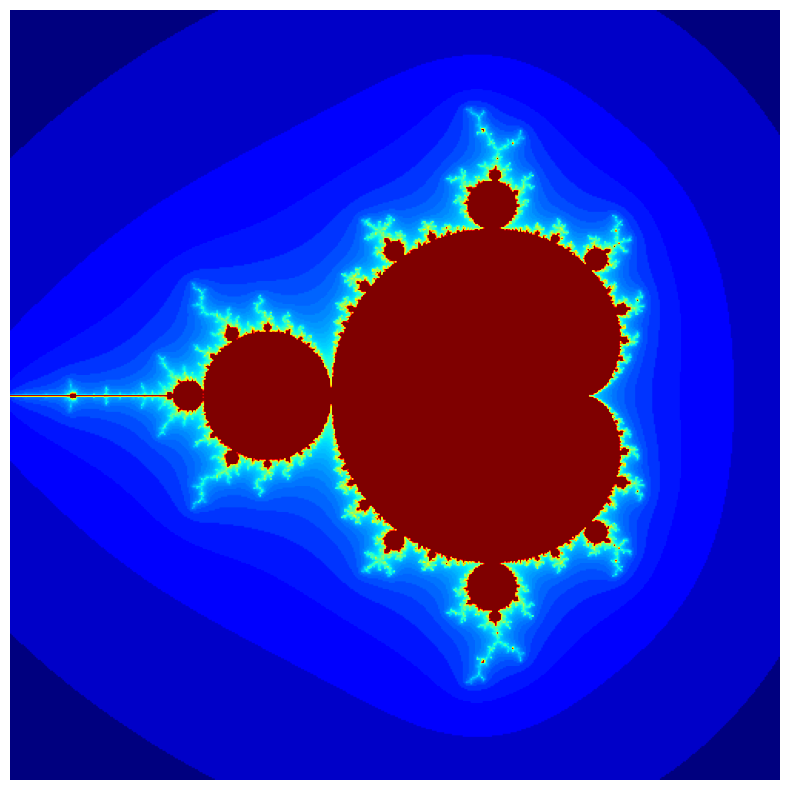

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(np.log(A), cmap=plt.cm.jet)

ax.set_axis_off()

Now let's have a mandelbrot function in Python

In [76]:
def mandelbrot(size, iterations, col):
    for i in range(0,size):
        cy = -1.5 + i / size * 3.0
        for j in range(0,size):
            cx = -2.0 + j / size * 3.0
            z0 = 0.0
            z1 = 0.0
            for n in range(0, iterations):
                z0_2 = z0 * z0
                z1_2 = z1 * z1
                if z0_2 + z1_2 <= 100:
                    z0_tmp = z0_2 - z1_2 + cx
                    z1 = 2 * z0 * z1 + cy
                    z0 = z0_tmp
                    col[i,j] = n;
                else:
                    break

In [77]:
size = 500
iterations = 1000

# clreate a size x szie array of integers
B = np.empty((size, size), dtype=np.int32)

In [78]:
mandelbrot(size, iterations, B)

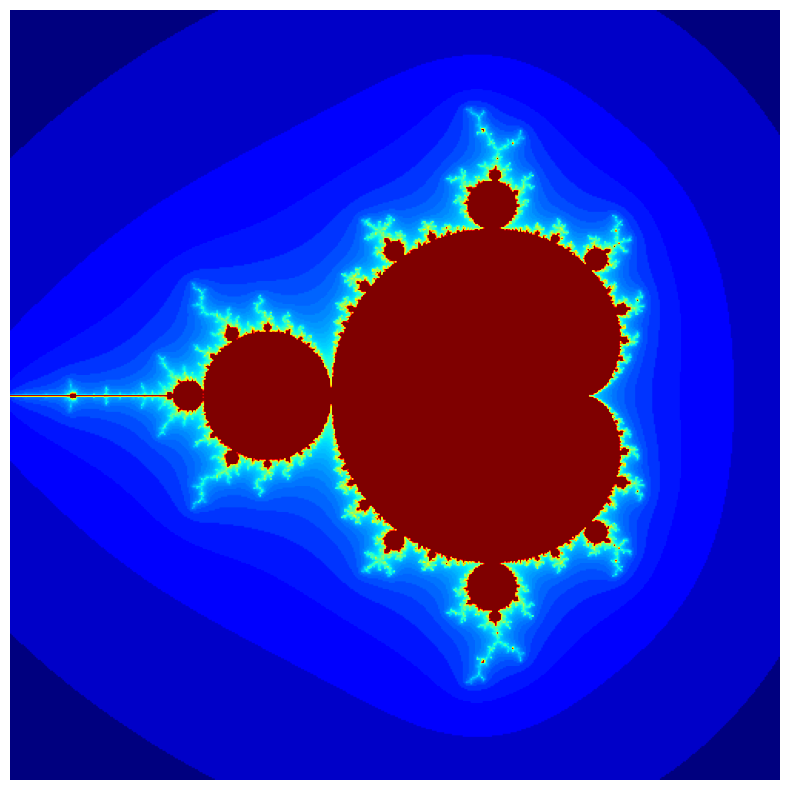

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(np.log(B), cmap=plt.cm.jet)

ax.set_axis_off()

In [80]:
import time

In [81]:
a = time.time()
lib.mandelbrot(size, iterations, ffi.cast("int *", A.ctypes.data))
b = time.time()
print(b-a)

0.3152174949645996


In [82]:
a = time.time()
mandelbrot(size, iterations, B)
b = time.time()
print(b-a)

11.626312494277954


In [83]:
11.929452896118164/0.3138425350189209

38.01094996699209

**Coding Time!**: Examine the Mandelbrot set function and develop something similar for the Julia Set:

That is, find such points $p\in C$ that the following series:

$$
\begin{cases}
    z_0 = p \\
    z_{n+1} = z_{n}^2 + c
\end{cases}
$$
does not diverge to $\infty$. $c$ should be a parameter.

In [ ]:
from cffi import FFI
ffi = FFI()

lib = ffi.dlopen('examplelib/libjulia.so')
ffi.cdef('''
void julia(int size, int iterations, int *col, double dx, double dy);
''')
# We show that here we imported all, but we will use only the mandelbrot()

In [ ]:
import numpy as np 

size = 1000
iterations = 1000
dx = -0.8
dy = 0.156

# clreate a size x szie array of integers
A = np.empty((size, size), dtype=np.int32)

In [ ]:
# mandelbrot() function fills the array with data
lib.julia(size, iterations, ffi.cast("int *", A.ctypes.data), dx, dy)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.log(A), cmap=plt.cm.jet)
ax.set_axis_off()

# Appendix
Here sources of programs used for this lecture are provided for reference.

``CMakeLists.tzt:``

In [ ]:
cat ./examplelib/CMakeLists.txt

``example1.c``, ``example2.c``, ``example3.c``, ``example4.c``:

In [ ]:
cat ./examplelib/example1.c

In [ ]:
cat ./examplelib/example2.c

In [ ]:
cat ./examplelib/example3.c

In [ ]:
cat ./examplelib/example4.c

``julia.c`` and ``mandelbrot.c``:

In [ ]:
cat ./examplelib/julia.c

In [ ]:
cat ./examplelib/mandelbrot.c